In [1]:
%pip install mlflow

Note: you may need to restart the kernel to use updated packages.


In [1]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [2]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

In [3]:
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
data = pd.read_csv("../../standardized_datasets/2020-05-27_filtered_countries_julius_complete.csv", index_col=['country', 'date'])
data.drop(columns='cumulative_daily_change_total', inplace=True)
data.head()

confirmed  deaths  recovered  hdi_2018  \
country date                                                 
USA     2020-01-22        1.0     0.0        0.0      0.92   
        2020-01-23        1.0     0.0        0.0      0.92   
        2020-01-24        2.0     0.0        0.0      0.92   
        2020-01-25        2.0     0.0        0.0      0.92   
        2020-01-26        5.0     0.0        0.0      0.92   

                    population_total_2020  population_density_2020  \
country date                                                         
USA     2020-01-22             331002.647                   36.185   
        2020-01-23             331002.647                   36.185   
        2020-01-24             331002.647                   36.185   
        2020-01-25             331002.647                   36.185   
        2020-01-26             331002.647                   36.185   

                    cumulative_total  cumulative_total_per_thousand  retail  \
country date                                                                  
USA     2020-01-22               NaN                            NaN     NaN   
        2020-01-23               NaN                            NaN     NaN   
        2020-01-24               NaN                            NaN     NaN   
        2020-01-25               NaN                            NaN     NaN   
        2020-01-26               NaN                            NaN     NaN   

                    grocery and pharmacy  parks  transit stations  workplaces  \
country date                                                                    
USA     2020-01-22                   NaN    NaN               NaN         NaN   
        2020-01-23                   NaN    NaN               NaN         NaN   
        2020-01-24                   NaN    NaN               NaN         NaN   
        2020-01-25                   NaN    NaN               NaN         NaN   
        2020-01-26                   NaN    NaN               NaN         NaN   

                    residential  driving  transit  walking  pm2.5 value  
country date                                                             
USA     2020-01-22          NaN     3.01     1.06    -2.96          NaN  
        2020-01-23          NaN     7.90     3.29     0.83          NaN  
        2020-01-24          NaN    24.70    13.06    26.67          NaN  
        2020-01-25          NaN    20.92     1.88    39.61          NaN  
        2020-01-26          NaN   -12.68   -18.65   -10.10          NaN

In [4]:
tf.config.experimental.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [36]:
#Defining characteristic variables
past = 10 #Past episodes to consider
future_target = 1

logdir = "./logs"# directory for logs

In [190]:
X.shape

(1839, 10, 1)

In [191]:
y.shape

(1839, 1)

In [147]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([16, 32]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.2))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))
HP_LAYER_1= hp.HParam('layer_1', hp.Discrete([30,35,40,45,50,55,60]))
HP_LAYER_2=hp.HParam('layer_2', hp.Discrete([90]))
HP_LAYER_3=hp.HParam('layer_3',hp.Discrete([74]))
HP_OUT = hp.HParam('output', hp.Discrete([1]))
METRIC_ACCURACY = 'accuracy'
with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER, HP_LAYER_1,HP_LAYER_2,HP_LAYER_3, HP_OUT],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )


In [192]:
def lstm_model(hparams, X, y):
    np.random.seed(1234)
    tf.random.set_seed(1234)
    model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(hparams[HP_LAYER_1], activation='relu', return_sequences=True, input_shape=X.shape[-2:]),
    tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
    tf.keras.layers.LSTM(hparams[HP_LAYER_2], return_sequences=True,activation='relu'),
    tf.keras.layers.LSTM(hparams[HP_LAYER_3], activation='relu'),
    tf.keras.layers.Dense(hparams[HP_OUT]),
  ])
    model.compile(
      optimizer=hparams[HP_OPTIMIZER],
      loss='mse',
      metrics=['accuracy'],
  )

    model.fit(X, y, epochs=100)
    _, accuracy = model.evaluate(X, y)
    
    callbacks=[
        tf.keras.callbacks.TensorBoard(logdir),  # log metrics
        hp.KerasCallback(logdir, hparams),  # log hparams
    ]
   
    return accuracy

In [193]:
germany = data.loc['Germany'].sort_values(by='date')
#pd.set_option('display.max_rows', 100)
germany = germany.loc['2020-02-15':'2020-05-02']
germany.interpolate(inplace=True, limit_area=None)
germany

confirmed  deaths  recovered  hdi_2018  population_total_2020  \
date                                                                        
2020-02-15       16.0     0.0        1.0     0.939              83783.945   
2020-02-16       16.0     0.0        1.0     0.939              83783.945   
2020-02-17       16.0     0.0        1.0     0.939              83783.945   
2020-02-18       16.0     0.0       12.0     0.939              83783.945   
2020-02-19       16.0     0.0       12.0     0.939              83783.945   
...               ...     ...        ...       ...                    ...   
2020-04-28   159912.0  6314.0   117400.0     0.939              83783.945   
2020-04-29   161539.0  6467.0   120400.0     0.939              83783.945   
2020-04-30   163009.0  6623.0   123500.0     0.939              83783.945   
2020-05-01   164077.0  6736.0   126900.0     0.939              83783.945   
2020-05-02   164967.0  6812.0   129000.0     0.939              83783.945   

            population_density_2020  cumulative_total  \
date                                                    
2020-02-15                  240.372               NaN   
2020-02-16                  240.372               NaN   
2020-02-17                  240.372               NaN   
2020-02-18                  240.372               NaN   
2020-02-19                  240.372               NaN   
...                             ...               ...   
2020-04-28                  240.372         2440358.0   
2020-04-29                  240.372         2440358.0   
2020-04-30                  240.372         2440358.0   
2020-05-01                  240.372         2440358.0   
2020-05-02                  240.372         2440358.0   

            cumulative_total_per_thousand  retail  grocery and pharmacy  \
date                                                                      
2020-02-15                            NaN     6.0                   1.0   
2020-02-16                            NaN     7.0                  10.0   
2020-02-17                            NaN     2.0                   2.0   
2020-02-18                            NaN     2.0                   2.0   
2020-02-19                            NaN     3.0                   0.0   
...                                   ...     ...                   ...   
2020-04-28                         29.127   -48.0                 -10.0   
2020-04-29                         29.127   -46.0                   1.0   
2020-04-30                         29.127   -34.0                  19.0   
2020-05-01                         29.127   -82.0                 -92.0   
2020-05-02                         29.127   -46.0                   3.0   

            parks  transit stations  workplaces  residential  driving  \
date                                                                    
2020-02-15   45.0              10.0         0.0         -1.0    28.00   
2020-02-16    9.0               6.0        -1.0          0.0     9.63   
2020-02-17    7.0               1.0        -2.0          0.0     8.00   
2020-02-18   10.0               1.0        -1.0          1.0     9.42   
2020-02-19    6.0              -1.0        -1.0          1.0    10.81   
...           ...               ...         ...          ...      ...   
2020-04-28   19.0             -43.0       -33.0         13.0   -30.96   
2020-04-29   12.0             -43.0       -33.0         13.0   -29.39   
2020-04-30   -8.0             -39.0       -34.0         12.0   -29.70   
2020-05-01   17.0             -67.0       -84.0         28.0   -37.54   
2020-05-02  -18.0             -42.0       -20.0          9.0   -34.09   

            transit  walking  pm2.5 value  
date                                       
2020-02-15    25.20    61.49         11.0  
2020-02-16    14.91    -1.32         11.0  
2020-02-17    57.64    11.55         11.0  
2020-02-18    40.18    15.71         11.0  
2020-02-19    32.15     9.61         11.0  
...             ...      ...      

In [194]:
def extrapolate(series):
    first_valid_entries=[0,0]
    i=0
    for entry in series:
        if i==2:
            break
        if np.isnan(entry)==False:
            first_valid_entries[i]=entry
            i=i+1

    gradient = first_valid_entries[1]-first_valid_entries[0]
    index = int(np.flatnonzero(series == first_valid_entries[0]))
    while index>0:
        series.iloc[index-1] = series.iloc[index] - gradient
        index = index - 1

    series[series < 0] = 0


extrapolate(germany.cumulative_total)
extrapolate(germany.cumulative_total_per_thousand)
germany
#germany.info()

confirmed  deaths  recovered  hdi_2018  population_total_2020  \
date                                                                        
2020-02-15       16.0     0.0        1.0     0.939              83783.945   
2020-02-16       16.0     0.0        1.0     0.939              83783.945   
2020-02-17       16.0     0.0        1.0     0.939              83783.945   
2020-02-18       16.0     0.0       12.0     0.939              83783.945   
2020-02-19       16.0     0.0       12.0     0.939              83783.945   
...               ...     ...        ...       ...                    ...   
2020-04-28   159912.0  6314.0   117400.0     0.939              83783.945   
2020-04-29   161539.0  6467.0   120400.0     0.939              83783.945   
2020-04-30   163009.0  6623.0   123500.0     0.939              83783.945   
2020-05-01   164077.0  6736.0   126900.0     0.939              83783.945   
2020-05-02   164967.0  6812.0   129000.0     0.939              83783.945   

            population_density_2020  cumulative_total  \
date                                                    
2020-02-15                  240.372               0.0   
2020-02-16                  240.372               0.0   
2020-02-17                  240.372               0.0   
2020-02-18                  240.372               0.0   
2020-02-19                  240.372               0.0   
...                             ...               ...   
2020-04-28                  240.372         2440358.0   
2020-04-29                  240.372         2440358.0   
2020-04-30                  240.372         2440358.0   
2020-05-01                  240.372         2440358.0   
2020-05-02                  240.372         2440358.0   

            cumulative_total_per_thousand  retail  grocery and pharmacy  \
date                                                                      
2020-02-15                          0.000     6.0                   1.0   
2020-02-16                          0.000     7.0                  10.0   
2020-02-17                          0.000     2.0                   2.0   
2020-02-18                          0.000     2.0                   2.0   
2020-02-19                          0.000     3.0                   0.0   
...                                   ...     ...                   ...   
2020-04-28                         29.127   -48.0                 -10.0   
2020-04-29                         29.127   -46.0                   1.0   
2020-04-30                         29.127   -34.0                  19.0   
2020-05-01                         29.127   -82.0                 -92.0   
2020-05-02                         29.127   -46.0                   3.0   

            parks  transit stations  workplaces  residential  driving  \
date                                                                    
2020-02-15   45.0              10.0         0.0         -1.0    28.00   
2020-02-16    9.0               6.0        -1.0          0.0     9.63   
2020-02-17    7.0               1.0        -2.0          0.0     8.00   
2020-02-18   10.0               1.0        -1.0          1.0     9.42   
2020-02-19    6.0              -1.0        -1.0          1.0    10.81   
...           ...               ...         ...          ...      ...   
2020-04-28   19.0             -43.0       -33.0         13.0   -30.96   
2020-04-29   12.0             -43.0       -33.0         13.0   -29.39   
2020-04-30   -8.0             -39.0       -34.0         12.0   -29.70   
2020-05-01   17.0             -67.0       -84.0         28.0   -37.54   
2020-05-02  -18.0             -42.0       -20.0          9.0   -34.09   

            transit  walking  pm2.5 value  
date                                       
2020-02-15    25.20    61.49         11.0  
2020-02-16    14.91    -1.32         11.0  
2020-02-17    57.64    11.55         11.0  
2020-02-18    40.18    15.71         11.0  
2020-02-19    32.15     9.61         11.0  
...             ...      ...      

In [195]:
germany.index = pd.to_datetime(germany.index)
germany = germany.resample('H').interpolate(limit_area=None)
#germany

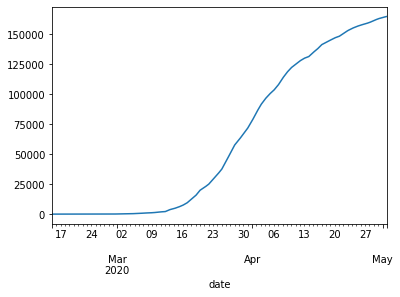

In [196]:
dataset = germany.confirmed
dataset.plot()

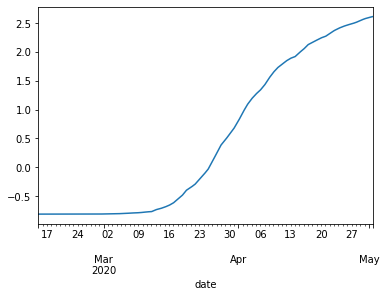

In [197]:
train_split_rows = int(dataset.shape[0]*0.8)


training_dataset = dataset[:train_split_rows]
mean = training_dataset.mean(axis=0)
std = training_dataset.std(axis=0)
dataset_scaled = ((dataset) - mean) / std
#dataset_scaled = dataset #TEMP
dataset_scaled.plot()

In [198]:
def split_rolling_window(df, past, future_target=1):
    data = []
    labels = []
    window_start = 0
    window_end = past
    while window_end <= df.shape[0]-future_target: 
        data.append(df.iloc[window_start:window_end].values)
        labels.append(df.iloc[window_end:window_end+future_target].values)
        window_start += 1
        window_end += 1
    
    
    X = np.stack(data)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    y = np.stack(labels)
    return X,y
    
X, y = split_rolling_window(dataset_scaled, past)
print(X.shape)
y.shape

(1839, 10, 1)


(1839, 1)

In [199]:
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        accuracy = lstm_model(hparams, X, y)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)


In [ ]:
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
    for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
        for optimizer in HP_OPTIMIZER.domain.values:
            for layer_1 in HP_LAYER_1.domain.values:
                for layer_2 in HP_LAYER_2.domain.values:
                    for layer_3 in HP_LAYER_3.domain.values:
                        for out in HP_OUT.domain.values:
                            hparams = {
                                  HP_NUM_UNITS: num_units,
                                  HP_DROPOUT: dropout_rate,
                                  HP_OPTIMIZER: optimizer,
                                  HP_LAYER_1: layer_1,
                                  HP_LAYER_2: layer_2,
                                  HP_LAYER_3: layer_3,
                                  HP_OUT: out 
                                  }
                            run_name = "run-%d" % session_num
                            print('--- Starting trial: %s' % run_name)
                            print({h.name: hparams[h] for h in hparams})
                            run('logs/hparam_tuning/' + run_name, hparams)
                            session_num += 1

In [179]:
%tensorboard --logdir logs/hparam_tuning

Reusing TensorBoard on port 6006 (pid 10265), started 0:03:40 ago. (Use '!kill 10265' to kill it.)